In [2]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/CS 5228 Project/Team Intelligent Realtors'

/content/drive/MyDrive/CS 5228 Project/Team Intelligent Realtors


In [4]:
data = pd.read_csv('final_train.csv')
#data = data.drop(columns=['Unnamed: 0'])

In [5]:
data.head()

,resale_price,region,floor_area_sqm,latitude,longitude,lease_commence_date,min_mrt_dist,cbd_dist,min_pschool_dist,min_hawk_dist,min_com_dist,min_mall_dist,mrt,children,adults,retired,sale_month,sale_year,storey_mid,lease_period,flat_type_ord,flat_model_ord,mature_town,malls,pschools,ccenter,hawkers
0,209700.0,3,118.0,1.369008,103.958697,1989,1137.651115,15274.17540,343.631728,944.997805,2307.215412,1028.771485,1,34210,87510,18250,8,2001,2,87,4,1,1,2,6,0,1
1,402300.0,4,110.0,1.399007,103.906991,2003,118.453389,14246.27116,160.101930,3773.975238,1455.535626,802.250665,13,31860,67170,10790,10,2014,11,88,5,1,0,5,13,1,0
2,351000.0,4,112.0,1.388348,103.873815,2004,479.542021,11915.30307,183.944032,1797.717863,1445.013356,450.917543,3,55000,127610,24120,9,2020,2,83,5,2,0,3,3,1,0
3,151200.0,2,67.0,1.318493,103.766702,1980,421.345802,10200.27526,303.220794,615.444280,2386.694324,454.833506,1,17490,52740,21500,10,2000,8,79,3,1,1,3,4,0,4
4,318600.0,2,73.0,1.348149,103.742658,1985,775.005151,14074.20821,233.531623,760.362573,1800.058269,764.631406,1,29610,86560,23250,1,2013,8,71,3,1,0,1,7,1,2


In [6]:
data.describe()

,resale_price,region,floor_area_sqm,latitude,longitude,lease_commence_date,min_mrt_dist,cbd_dist,min_pschool_dist,min_hawk_dist,min_com_dist,min_mall_dist,mrt,children,adults,retired,sale_month,sale_year,storey_mid,lease_period,flat_type_ord,flat_model_ord,mature_town,malls,pschools,ccenter,hawkers
count,4.317320e+05,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000,431732.000000
mean,3.018196e+05,2.970616,96.970064,1.364939,103.836492,1989.421004,652.651433,12418.355922,393.152936,1004.214581,1967.235395,705.135580,2.684091,40288.822163,111696.417175,31175.706990,6.578167,2008.795389,7.741643,79.625615,4.067350,1.148926,0.471045,2.614759,5.792883,0.853184,2.898312
std,1.298623e+05,1.387845,25.190664,0.042829,0.073527,10.254055,383.748875,4469.711950,230.101871,940.906197,1085.416736,403.497913,2.763529,16888.284015,43379.976549,12737.562334,3.375212,6.064529,4.854703,10.655984,0.932833,0.370678,0.499161,1.887819,2.490143,0.933804,2.915427
min,2.970000e+04,1.000000,31.000000,1.270380,103.685228,1966.000000,22.112447,592.121638,33.363835,1.875576,110.785656,1.849579,0.000000,140.000000,390.000000,300.000000,1.000000,2000.000000,2.000000,45.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.052000e+05,2.000000,74.000000,1.336154,103.772439,1983.000000,367.596787,9488.469751,229.967066,349.689847,1147.365213,390.494209,1.000000,28200.000000,71750.000000,22180.000000,4.000000,2003.000000,5.000000,72.000000,3.000000,1.000000,0.000000,1.000000,4.000000,0.000000,1.000000
50%,2.839500e+05,3.000000,99.000000,1.358958,103.840159,1988.000000,587.644875,13196.165350,349.780047,676.229410,1767.725489,639.216433,2.000000,42740.000000,109510.000000,29560.000000,7.000000,2008.000000,8.000000,80.000000,4.000000,1.000000,0.000000,3.000000,5.000000,1.000000,2.000000
75%,3.735000e+05,4.000000,114.000000,1.389004,103.895779,1997.000000,860.115900,15987.872230,504.321791,1275.805557,2534.648530,956.131723,3.000000,55470.000000,156280.000000,39680.000000,9.000000,2014.000000,11.000000,89.000000,5.000000,1.000000,1.000000,4.000000,7.000000,1.000000,5.000000
max,1.123200e+06,5.000000,280.000000,1.457071,103.987805,2019.000000,3515.776371,20225.103700,3302.369322,4816.062542,5501.872083,2335.423299,16.000000,64430.000000,170260.000000,62770.000000,12.000000,2020.000000,50.000000,101.000000,7.000000,3.000000,1.000000,22.000000,15.000000,6.000000,15.000000


Multicollinearity check

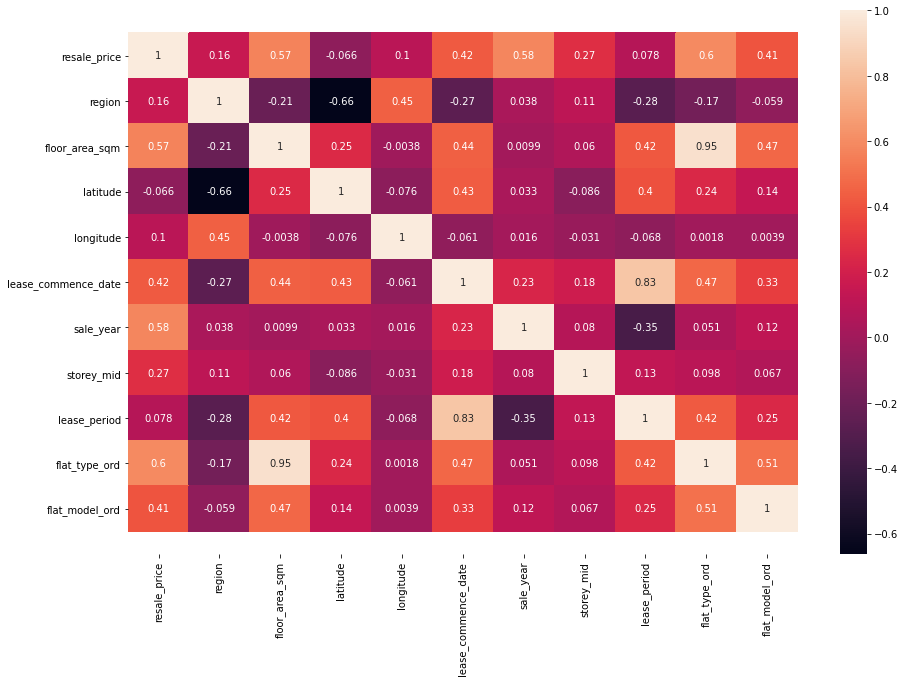

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize']=[15,10]


data_Set = data[['resale_price','region','floor_area_sqm','latitude','longitude','lease_commence_date','sale_year','storey_mid','lease_period','flat_type_ord','flat_model_ord']]

corrMatrix=data_Set.corr()

sns.heatmap(corrMatrix,annot=True)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [7]:
pip install catboost

     |████████████████████████████████| 67.3MB 71kB/s 


In [ ]:
len(data.columns)

27

# Feature Selection

Using RFE

Now, we have 26 predictor features. To build the model using Recursive Feature Elimination (RFE), we need to tell RFE how many features we want in the final model. It then runs a feature elimination algorithm.

Note that the number of features to be used in the model is a hyperparameter.

Moreover, as noted before, there might be an issue with dimensionality and probably a lot of the dummy variables might not contain much data. Hence, we will create a new model using feature selection to remove features that are causing noise in the catboost model.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# step-1: create a cross-validation scheme

data = pd.read_csv('final_train.csv')
data_Set = data.copy() 
col = data_Set.columns.tolist()

data_Set = data_Set.reindex(columns = col)

Y = data_Set.iloc[:,0]
X = data_Set.iloc[:, 1:len(col)]


### Standardization
num_data = X.select_dtypes(include=np.number)
cat_data = X.select_dtypes(exclude=np.number)
x_scaler = StandardScaler()
num_scaled = x_scaler.fit_transform(num_data)
num_scaled = pd.DataFrame(num_scaled,columns=num_data.columns)
X = pd.concat([num_scaled.reset_index(drop=True),cat_data.reset_index(drop=True)],axis=1)


X_train, X_test, y_train, y_test = train_test_split( X, Y, train_size = 0.8, stratify = X['region'],random_state = 50)
y_test = y_test.squeeze()
y_test = np.sqrt(y_test)
y_train = np.sqrt(y_train)


folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(15, 23))}]


# step-3: perform grid search
# 3.1 specify model
clf_cat=CatBoostRegressor(learning_rate=0.4,depth=8).fit(X_train,y_train,eval_set=(X_test, y_test))

rfe = RFE(clf_cat)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('Negative Mean Squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

As found by above step, the optimal number of feature is 19, so we find most important 19 features using RFE

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error


data = pd.read_csv('final_train.csv')
data_Set = data.copy() 

col = data_Set.columns.tolist()

data_Set = data_Set.reindex(columns = col)

Y = data_Set.iloc[:,0]
X = data_Set.iloc[:, 1:len(col)]


### Standardization
num_data = X.select_dtypes(include=np.number)
cat_data = X.select_dtypes(exclude=np.number)
x_scaler = StandardScaler()
num_scaled = x_scaler.fit_transform(num_data)
num_scaled = pd.DataFrame(num_scaled,columns=num_data.columns)
X = pd.concat([num_scaled.reset_index(drop=True),cat_data.reset_index(drop=True)],axis=1)


X_train, X_test, y_train, y_test = train_test_split( X, Y, train_size = 0.8, stratify = X['region'],random_state = 50)
y_test = y_test.squeeze()
y_test = np.sqrt(y_test)
y_train = np.sqrt(y_train)

clf_cat=CatBoostRegressor(learning_rate=0.4,depth=8) #.fit(X_train,y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))

rfe = RFE(clf_cat, n_features_to_select=19)             
rfe = rfe.fit(X_train, y_train)

# K Fold Cross Validation

We use most important 19 features found through RFE to train the model and do cross validation

In [16]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error


data = pd.read_csv('final_train.csv')

data_Set = data[['resale_price','region', 'floor_area_sqm', 'latitude', 'longitude', 'lease_commence_date', 'min_mrt_dist', 'cbd_dist', 'min_hawk_dist', 'min_com_dist', 'min_mall_dist', 'mrt', 'adult_Perc', 'sale_month', 'sale_year', 'storey_mid', 'lease_period', 'flat_type_ord','flat_model_ord', 'mature_town']]

col = data_Set.columns.tolist()

data_Set = data_Set.reindex(columns = col)

y = data_Set.iloc[:,0]
X = data_Set.iloc[:, 1:len(col)]


### Standardization
num_data = X.select_dtypes(include=np.number)
cat_data = X.select_dtypes(exclude=np.number)
x_scaler = StandardScaler()
num_scaled = x_scaler.fit_transform(num_data)
num_scaled = pd.DataFrame(num_scaled,columns=num_data.columns)
X = pd.concat([num_scaled.reset_index(drop=True),cat_data.reset_index(drop=True)],axis=1)

kf = KFold(n_splits=5)
rmse = []

for train_index, val_index in kf.split(X):
    # Create the next combination of training and validation folds
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    y_test = np.sqrt(y_test)
    y_train = np.sqrt(y_train)

    #categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
    #print(categorical_features_indices)
    #clf_cat=CatBoostRegressor(learning_rate=0.4,depth=8).fit(X_train,y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
    clf_cat=CatBoostRegressor(learning_rate=0.4,depth=8).fit(X_train,y_train,eval_set=(X_test, y_test))
    y_pred1 = clf_cat.predict(X_test)

    val = np.sqrt(mean_squared_error(y_test**2, y_pred1**2))
    rmse.append(int(val))
    
print('RMSE list: ',rmse)
print('Average rmse: {:.3f}'.format(np.mean(rmse)))

Streaming output truncated to the last 5000 lines.
23:	learn: 21.0309042	test: 20.9640303	best: 20.9640303 (23)	total: 1.94s	remaining: 1m 18s
24:	learn: 20.8557767	test: 20.8000011	best: 20.8000011 (24)	total: 2.03s	remaining: 1m 19s
25:	learn: 20.7139246	test: 20.6552703	best: 20.6552703 (25)	total: 2.1s	remaining: 1m 18s
26:	learn: 20.5548176	test: 20.4860430	best: 20.4860430 (26)	total: 2.17s	remaining: 1m 18s
27:	learn: 20.4117064	test: 20.3410418	best: 20.3410418 (27)	total: 2.26s	remaining: 1m 18s
28:	learn: 20.3010055	test: 20.2373257	best: 20.2373257 (28)	total: 2.33s	remaining: 1m 18s
29:	learn: 20.1319335	test: 20.0681989	best: 20.0681989 (29)	total: 2.41s	remaining: 1m 17s
30:	learn: 19.9192161	test: 19.8570248	best: 19.8570248 (30)	total: 2.5s	remaining: 1m 18s
31:	learn: 19.7087275	test: 19.6491278	best: 19.6491278 (31)	total: 2.59s	remaining: 1m 18s
32:	learn: 19.5993079	test: 19.5459461	best: 19.5459461 (32)	total: 2.66s	remaining: 1m 18s
33:	learn: 19.5078134	test: 19.

In [17]:
print('RMSE list: ',rmse)
print('Average rmse: {:.3f}'.format(np.mean(rmse)))

RMSE list:  [16181, 16405, 16325, 16217, 16382]
Average rmse: 16302.000


In [ ]:
print('RMSE list: ',rmse)
print('Average rmse: {:.3f}'.format(np.mean(rmse)))

RMSE list:  [16152, 16429, 16363, 16212, 16418]
Average rmse: 16314.800


# Train and Validation analysis

In [12]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error


data = pd.read_csv('final_train.csv')


data_Set = data[['resale_price','region', 'floor_area_sqm', 'latitude', 'longitude', 'lease_commence_date', 'min_mrt_dist', 'cbd_dist', 'min_hawk_dist', 'min_com_dist', 'min_mall_dist', 'mrt', 'adult_Perc', 'sale_month', 'sale_year', 'storey_mid', 'lease_period', 'flat_type_ord','flat_model_ord', 'mature_town']]

col = data_Set.columns.tolist()

data_Set = data_Set.reindex(columns = col)

Y = data_Set.iloc[:,0]
X = data_Set.iloc[:, 1:len(col)]


### Standardization
num_data = X.select_dtypes(include=np.number)
cat_data = X.select_dtypes(exclude=np.number)
x_scaler = StandardScaler()
num_scaled = x_scaler.fit_transform(num_data)
num_scaled = pd.DataFrame(num_scaled,columns=num_data.columns)
X = pd.concat([num_scaled.reset_index(drop=True),cat_data.reset_index(drop=True)],axis=1)

print(type(X))

X_train, X_test, y_train, y_test = train_test_split( X, Y, train_size = 0.8, stratify = X['region'],random_state = 50)
y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_test = np.sqrt(y_test)
y_train = np.sqrt(y_train)

#categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
#print(categorical_features_indices)
clf_cat=CatBoostRegressor(learning_rate=0.4,depth=8).fit(X_train,y_train,eval_set=(X_test, y_test))

<class 'pandas.core.frame.DataFrame'>
0:	learn: 77.6976360	test: 77.6933949	best: 77.6933949 (0)	total: 90.7ms	remaining: 1m 30s
1:	learn: 55.8638127	test: 55.7054961	best: 55.7054961 (1)	total: 174ms	remaining: 1m 26s
2:	learn: 44.0339260	test: 43.9046442	best: 43.9046442 (2)	total: 266ms	remaining: 1m 28s
3:	learn: 37.7566088	test: 37.5949449	best: 37.5949449 (3)	total: 353ms	remaining: 1m 27s
4:	learn: 33.3843624	test: 33.2879987	best: 33.2879987 (4)	total: 441ms	remaining: 1m 27s
5:	learn: 30.9354791	test: 30.8577676	best: 30.8577676 (5)	total: 524ms	remaining: 1m 26s
6:	learn: 29.2930557	test: 29.2302882	best: 29.2302882 (6)	total: 602ms	remaining: 1m 25s
7:	learn: 28.2200174	test: 28.1734014	best: 28.1734014 (7)	total: 679ms	remaining: 1m 24s
8:	learn: 27.2226595	test: 27.1893529	best: 27.1893529 (8)	total: 759ms	remaining: 1m 23s
9:	learn: 26.3626922	test: 26.3423657	best: 26.3423657 (9)	total: 847ms	remaining: 1m 23s
10:	learn: 25.6863364	test: 25.6576303	best: 25.6576303 (10)	

In [13]:
from sklearn.metrics import mean_squared_error
y_pred = clf_cat.predict(X_test)
rmse =  np.sqrt(mean_squared_error(y_test**2, y_pred**2))
print(rmse)


16450.21276390866


In [14]:
validation = X_test.copy()
validation['True Price'] = y_test**2
validation['Predicted Price'] = y_pred**2
validation.to_csv('validation.csv',index=False)

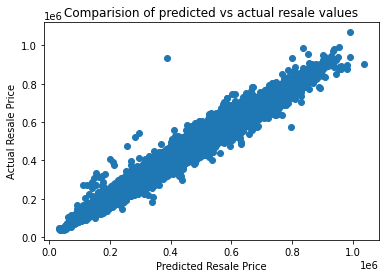

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(y_test**2,y_pred**2)
plt.title('Comparision of predicted vs actual resale values')
plt.xlabel('Predicted Resale Price')
plt.ylabel('Actual Resale Price')
plt.show()